Sujay Athrey - Indian Food Classifier

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D,Flatten,InputLayer,AveragePooling2D # type: ignore
from keras.layers import BatchNormalization,Dropout,Activation # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, MobileNetV2, EfficientNetB0 # type: ignore
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
from tensorflow.keras.preprocessing import image # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet_v2 import preprocess_input # type: ignore
import pickle

In [2]:
path = '/Users/sujayathrey/.cache/kagglehub/datasets/iamsouravbanerjee/indian-food-images-dataset/versions/5/Indian Food Images/Indian Food Images'
labels = os.listdir(path)

In [3]:
#create and populate a dataframe containing the image path and the label
df = pd.DataFrame(columns=['img_path','label'])

for label in labels:
    img_dir_path = os.path.join(path,label)
    for img in os.listdir(img_dir_path):
        img_path = os.path.join(img_dir_path,img)
        df.loc[df.shape[0]] = [img_path,label]
        
# shuffling dataset
df = df.sample(frac=1).reset_index(drop=True)

#Print out view of the created dataframe, col 0 is img path and col2 is image label
print(df.head())

                                            img_path           label
0  /Users/sujayathrey/.cache/kagglehub/datasets/i...         chapati
1  /Users/sujayathrey/.cache/kagglehub/datasets/i...    kadhi_pakoda
2  /Users/sujayathrey/.cache/kagglehub/datasets/i...      aloo_matar
3  /Users/sujayathrey/.cache/kagglehub/datasets/i...     shankarpali
4  /Users/sujayathrey/.cache/kagglehub/datasets/i...  chak_hao_kheer


In [4]:
#Print number of images, labels, and images per class of food
print("Number of images",df.shape[0])
print("Number of labels",df['label'].nunique())
print('There are only 50 images per class')

Number of images 4000
Number of labels 80
There are only 50 images per class


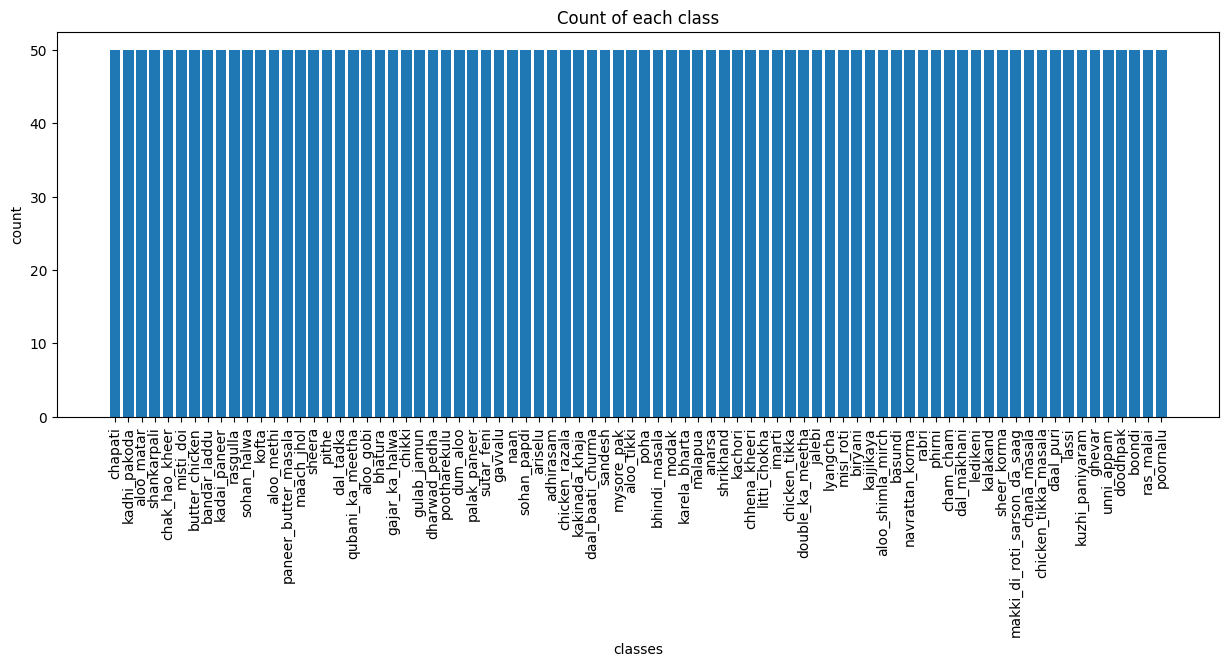

In [5]:
#Print out bar plot to depict 50 images total per class of food
plt.figure(figsize=(15,5))
plt.bar(x = df['label'].unique(),height=df['label'].value_counts())
plt.xlabel('classes')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.title('Count of each class')
plt.show()

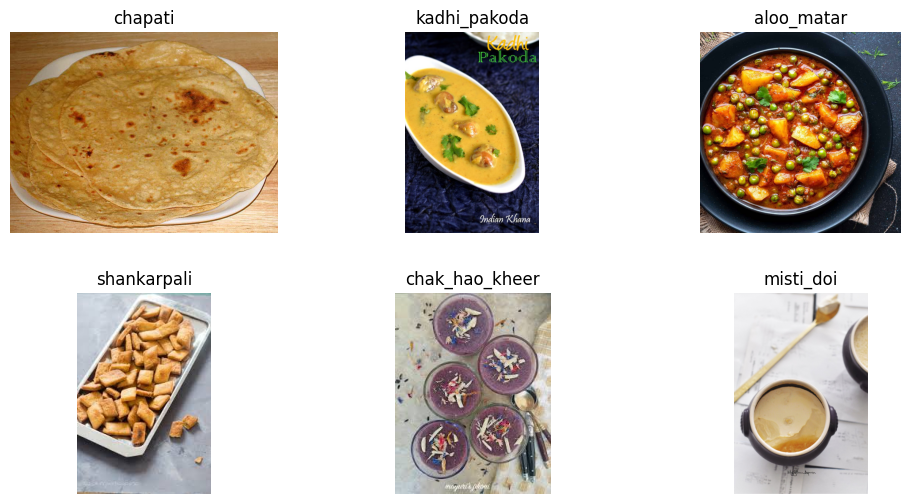

In [6]:
#Print out an image from each class
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        img_data = cv2.imread(df['img_path'][3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(df['label'][3*(i-1) + (j-1)])
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

In [7]:
#Split into training and testing datasets

x_train,x_val , y_train,y_val = train_test_split(df['img_path'],df['label'],random_state=42,test_size=0.2)

In [8]:
#Create a function to preprocess each image
def preprocess(img_paths):
    images = []
    for img_path in img_paths:
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, (224, 224))
        image_normalized = image_resized.astype('float32') / 255
        images.append(image_normalized)
    return np.array(images)

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Degree range for random rotations
    width_shift_range=0.2,     # Fraction of total width to shift images horizontally
    height_shift_range=0.2,    # Fraction of total height to shift images vertically
    shear_range=0.2,           # Shear angle in counter-clockwise direction
    zoom_range=0.2,            # Range for random zoom
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

train_dataset = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_train,'label':y_train}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    subset='training'  
)

Found 3200 validated image filenames belonging to 80 classes.


In [10]:
#create a dictionary of class indices for each image label (80 total labels = 80 indices from 0-79)
class_indices = train_dataset.class_indices

In [11]:
#display the class indices dictionary
print("Class Indices:")
print(class_indices)

Class Indices:
{'adhirasam': 0, 'aloo_gobi': 1, 'aloo_matar': 2, 'aloo_methi': 3, 'aloo_shimla_mirch': 4, 'aloo_tikki': 5, 'anarsa': 6, 'ariselu': 7, 'bandar_laddu': 8, 'basundi': 9, 'bhatura': 10, 'bhindi_masala': 11, 'biryani': 12, 'boondi': 13, 'butter_chicken': 14, 'chak_hao_kheer': 15, 'cham_cham': 16, 'chana_masala': 17, 'chapati': 18, 'chhena_kheeri': 19, 'chicken_razala': 20, 'chicken_tikka': 21, 'chicken_tikka_masala': 22, 'chikki': 23, 'daal_baati_churma': 24, 'daal_puri': 25, 'dal_makhani': 26, 'dal_tadka': 27, 'dharwad_pedha': 28, 'doodhpak': 29, 'double_ka_meetha': 30, 'dum_aloo': 31, 'gajar_ka_halwa': 32, 'gavvalu': 33, 'ghevar': 34, 'gulab_jamun': 35, 'imarti': 36, 'jalebi': 37, 'kachori': 38, 'kadai_paneer': 39, 'kadhi_pakoda': 40, 'kajjikaya': 41, 'kakinada_khaja': 42, 'kalakand': 43, 'karela_bharta': 44, 'kofta': 45, 'kuzhi_paniyaram': 46, 'lassi': 47, 'ledikeni': 48, 'litti_chokha': 49, 'lyangcha': 50, 'maach_jhol': 51, 'makki_di_roti_sarson_da_saag': 52, 'malapua': 

In [12]:
#flip the dictionary keys and values so that index is key and label is value
index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)


Index to Class Mapping:
{0: 'adhirasam', 1: 'aloo_gobi', 2: 'aloo_matar', 3: 'aloo_methi', 4: 'aloo_shimla_mirch', 5: 'aloo_tikki', 6: 'anarsa', 7: 'ariselu', 8: 'bandar_laddu', 9: 'basundi', 10: 'bhatura', 11: 'bhindi_masala', 12: 'biryani', 13: 'boondi', 14: 'butter_chicken', 15: 'chak_hao_kheer', 16: 'cham_cham', 17: 'chana_masala', 18: 'chapati', 19: 'chhena_kheeri', 20: 'chicken_razala', 21: 'chicken_tikka', 22: 'chicken_tikka_masala', 23: 'chikki', 24: 'daal_baati_churma', 25: 'daal_puri', 26: 'dal_makhani', 27: 'dal_tadka', 28: 'dharwad_pedha', 29: 'doodhpak', 30: 'double_ka_meetha', 31: 'dum_aloo', 32: 'gajar_ka_halwa', 33: 'gavvalu', 34: 'ghevar', 35: 'gulab_jamun', 36: 'imarti', 37: 'jalebi', 38: 'kachori', 39: 'kadai_paneer', 40: 'kadhi_pakoda', 41: 'kajjikaya', 42: 'kakinada_khaja', 43: 'kalakand', 44: 'karela_bharta', 45: 'kofta', 46: 'kuzhi_paniyaram', 47: 'lassi', 48: 'ledikeni', 49: 'litti_chokha', 50: 'lyangcha', 51: 'maach_jhol', 52: 'makki_di_roti_sarson_da_saag', 53

In [13]:
#create function to build and train model
def build_model(base):
    base_model = base
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(80, activation='softmax'),  # For binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
#mobilenetv2
mobilenet_model = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_mobilenet = mobilenet_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=50
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.0473 - loss: 4.4954
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 111us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - accuracy: 0.2206 - loss: 3.2161
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 314ms/step - accuracy: 0.2938 - loss: 2.7950
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.3672 - loss: 2.4415
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 332ms/step - accuracy: 0.4010 - loss: 2.2703
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 300ms/step - accuracy: 0.4413 - l

2024-12-26 17:36:42.706926: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - accuracy: 0.4598 - loss: 1.9492
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 301ms/step - accuracy: 0.5011 - loss: 1.8131
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - accuracy: 0.5416 - loss: 1.6719
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - accuracy: 0.5379 - loss: 1.6648
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 303ms/step - accuracy: 0.5583 - loss: 1.5499
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 306ms/step - accuracy: 0.5748 - loss:

2024-12-26 17:45:03.626818: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 305ms/step - accuracy: 0.6557 - loss: 1.1948
Epoch 46/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 47/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 304ms/step - accuracy: 0.6727 - loss: 1.1214
Epoch 48/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 49/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 305ms/step - accuracy: 0.6636 - loss: 1.1501
Epoch 50/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [ ]:
#inceptionV3
inceptionv3_model = build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_inception = inceptionv3_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=50,
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 682ms/step - accuracy: 0.0282 - loss: 4.5884
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 678ms/step - accuracy: 0.1295 - loss: 3.7041
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 707s 7s/step - accuracy: 0.1940 - loss: 3.2445
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 686ms/step - accuracy: 0.2291 - loss: 2.9910
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1549s 16s/step - accuracy: 0.2794 - loss: 2.8161
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 696ms/step - accuracy: 0.3033 - l

In [ ]:
#resnet50
resnet50_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_resnet = resnet50_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=50,
)

In [ ]:
#EfficientNet
efficientnet_model = build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_efficientnet = efficientnet_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=5
)

In [ ]:
#VGG16
vgg16_model = build_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_vgg16 = vgg16_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=5
)

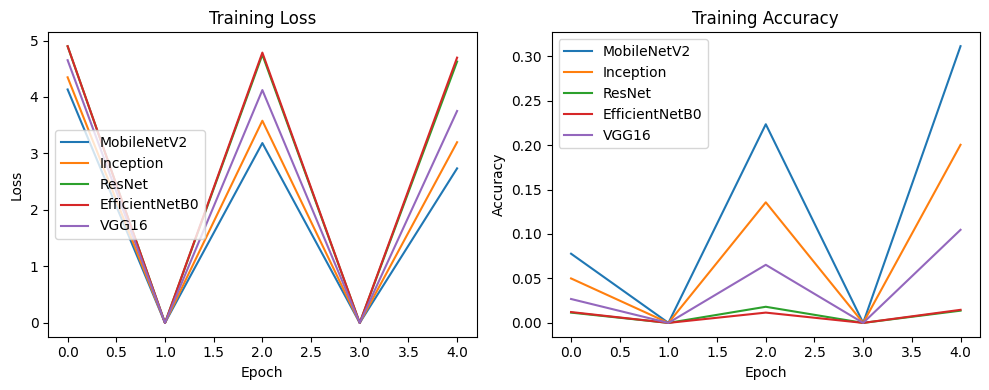

In [24]:
# Plot loss function
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2')
plt.plot(history_inception.history['loss'], label='Inception')
plt.plot(history_resnet.history['loss'], label='ResNet')
plt.plot(history_efficientnet.history['loss'], label='EfficientNetB0')  # Add EfficientNetB0
plt.plot(history_vgg16.history['loss'], label='VGG16')  # Add VGG16
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2')
plt.plot(history_inception.history['accuracy'], label='Inception')
plt.plot(history_resnet.history['accuracy'], label='ResNet')
plt.plot(history_efficientnet.history['accuracy'], label='EfficientNetB0')  # Add EfficientNetB0
plt.plot(history_vgg16.history['accuracy'], label='VGG16')  # Add VGG16
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
final_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [27]:
layer_list = (final_base_model.layers)
layer_list.reverse()

flag = True
for layers in layer_list:
    if flag:layers.trainable=True
    else:layers.trainable=False
    if 'Conv_1' in layers.name:flag = False


In [28]:
base_model = final_base_model

final_model = Sequential([
        base_model,
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(80, activation='softmax'),  # For binary classification
    ])

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_final = final_model.fit(
    train_dataset,
    steps_per_epoch=100,
    epochs=20,
)

In [ ]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['loss'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_final.history['accuracy'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# finding y_pred using x_val
y_pred = []
for img_path in x_val:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = final_model.predict(img_array,verbose=False)
    predicted_class_index = np.argmax(predictions)
    y_pred.append(index_to_class[predicted_class_index])

In [32]:
print(f"validation accuracy : {accuracy_score(y_val,y_pred)}")

validation accuracy : 0.455


In [ ]:
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        image = cv2.imread(x_val.values[3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(f"predicted : {y_pred[3*(i-1) + (j-1)]} \n actual : {y_val.values[3*(i-1) + (j-1)]} ")
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

In [34]:
print(classification_report(y_val,y_pred))

                              precision    recall  f1-score   support

                   adhirasam       0.50      0.45      0.48        11
                   aloo_gobi       0.40      0.25      0.31         8
                  aloo_matar       0.60      0.27      0.38        11
                  aloo_methi       0.30      0.67      0.41         9
           aloo_shimla_mirch       0.12      0.50      0.19         6
                  aloo_tikki       0.40      0.55      0.46        11
                      anarsa       0.67      0.25      0.36         8
                     ariselu       0.40      0.50      0.44        12
                bandar_laddu       0.57      0.57      0.57         7
                     basundi       0.17      0.09      0.12        11
                     bhatura       0.67      0.50      0.57        12
               bhindi_masala       0.25      0.33      0.29         9
                     biryani       0.35      0.75      0.48         8
                   